In [1]:
# Data from https://grouplens.org/datasets/movielens/latest/
# Put the downloaded csv files in the "Downloads" folder

import os
os.chdir("Downloads")
print(os.getcwd())


c:\Users\vonks\Documents\GitHub\Movie_Recs\Downloads


In [ ]:
import pandas as pd

ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

data = ratings.merge(movies, on="movieId", how="left")

In [ ]:
print(data.head(1))
#print(data.info())

print("# Users:", data['userId'].nunique())
print("# Movies:", data['movieId'].nunique())
print("# Ratings:", len(data))

duplicates = data.duplicated(subset=['userId', 'movieId'])
print("# Duplicates:", duplicates.sum())
print('# Missing:', data.isnull().sum())

   userId  movieId  rating   timestamp             title  \
0       1        1     4.0  1225734739  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
# Users: 330975
# Movies: 83239
# Ratings: 33832162
# Duplicates: 0
# Missing: userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64


In [ ]:
print(data['rating'].describe())
print(data['rating'].unique())

count    3.383216e+07
mean     3.542540e+00
std      1.063959e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64
[4.  4.5 5.  3.5 3.  2.  2.5 1.  1.5 0.5]


There seem to be no missing values or duplicates based on these results.
Ratings also vary from 0.5 to 5 which is expected. Next, distributions of the data will be visualized to check for any unexpected patterns etc.

If there were missing values I would have removed these, as it could introduce patterns based on missing values that could skew recommendations. In my opinion it is better to leave these rows out, recommendations can be made using similarities based on the other rows.

If there were duplicates, it would be necessary to investigate the nature of the duplication. If a duplication is of the same rating with the same movieID and userID, I would argue for removing them. 

If there are multiple ratings for the same movie with the same userID, I would argue for keeping only the latest timestep. In movie rating apps like "letterboxd", users can change their ratings so the last one should be used for user similarity.

## Data Exploration

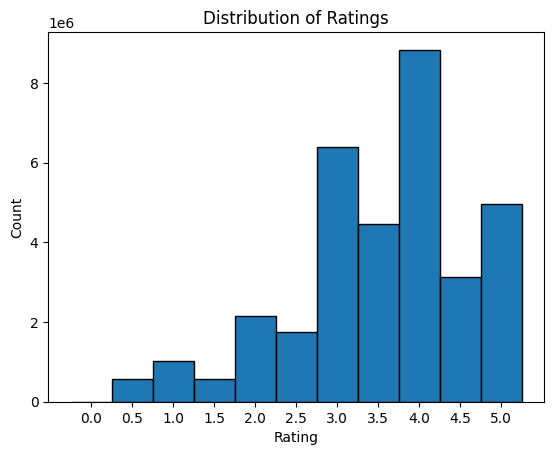

Mean rating: 3.54
Median rating: 4.00
Mode rating: 4.00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ratings = np.arange(0, 5.5, 0.5)  # Going to 5.5 to include the 5 bin

# Using np.histogram for time efficiency because data is large
counts, edges = np.histogram(data['rating'], bins=np.arange(-0.25, 5.25 + 0.5, 0.5))

plt.bar(ratings, counts, width=0.5, edgecolor='black')
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.xticks(ratings)
plt.show()

# Calculate mean, median, and mode of ratings
mean_rating = data['rating'].mean()
median_rating = data['rating'].median()
mode_rating = data['rating'].mode()[0]

print(f"Mean rating: {mean_rating:.2f}")
print(f"Median rating: {median_rating:.2f}")
print(f"Mode rating: {mode_rating:.2f}")


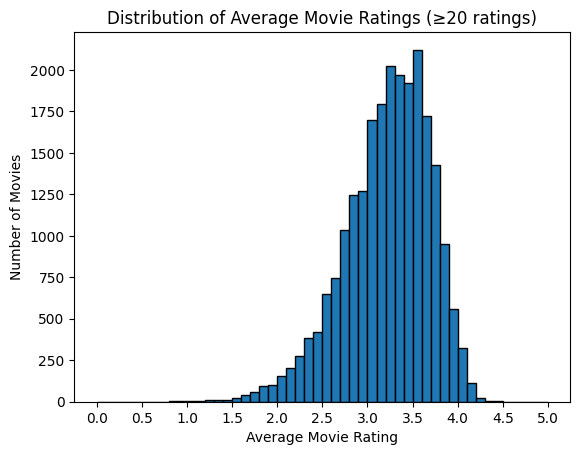

Mean of average ratings: 3.22
Median of average ratings: 3.27


In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Filter movies with >=20 ratings
movie_counts = data.groupby('movieId').size()
movies_with_enough_ratings = movie_counts[movie_counts >= 20].index
filtered_movies_data = data[data['movieId'].isin(movies_with_enough_ratings)]

# Compute average rating per movie after filtering
avg_ratings = filtered_movies_data.groupby('movieId')['rating'].mean().values

# Define bins of width 0.2
bin_width = 0.1
bins = np.arange(0, 5.0 + bin_width, bin_width)

# Compute histogram
counts, edges = np.histogram(avg_ratings, bins=bins)

# Compute bin centers (for centered bars)
bin_centers = edges[:-1] + bin_width / 2

# Plot
plt.bar(bin_centers, counts, width=bin_width, edgecolor='black', align='center')
plt.xlabel("Average Movie Rating")
plt.ylabel("Number of Movies")
plt.title("Distribution of Average Movie Ratings (≥20 ratings)")
plt.xticks(np.arange(0, 5.1, 0.5))
plt.show()

# Compute statistics for average ratings per movie
mean_avg = np.mean(avg_ratings)
median_avg = np.median(avg_ratings)

print(f"Mean of average ratings: {mean_avg:.2f}")
print(f"Median of average ratings: {median_avg:.2f}")


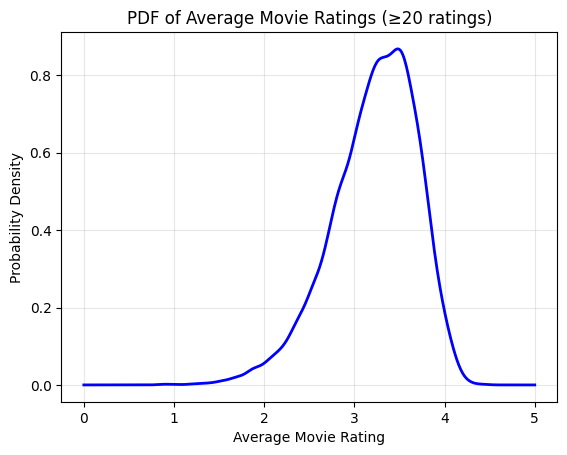

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Filter movies with >=20 ratings
movie_counts = data.groupby('movieId').size()
movies_with_enough_ratings = movie_counts[movie_counts >= 20].index
filtered_movies_data = data[data['movieId'].isin(movies_with_enough_ratings)]

# Compute average rating per movie after filtering
avg_ratings = filtered_movies_data.groupby('movieId')['rating'].mean().values

# Kernel Density Estimate (KDE)
kde = gaussian_kde(avg_ratings)

# Grid of x values (0–5 range for ratings)
x_grid = np.linspace(0, 5, 500)

# Evaluate KDE on the grid
pdf_values = kde(x_grid)

# Plot as line graph
plt.plot(x_grid, pdf_values, color='blue', lw=2)
plt.xlabel("Average Movie Rating")
plt.ylabel("Probability Density")
plt.title("PDF of Average Movie Ratings (≥20 ratings)")
plt.grid(True, alpha=0.3)
plt.show()


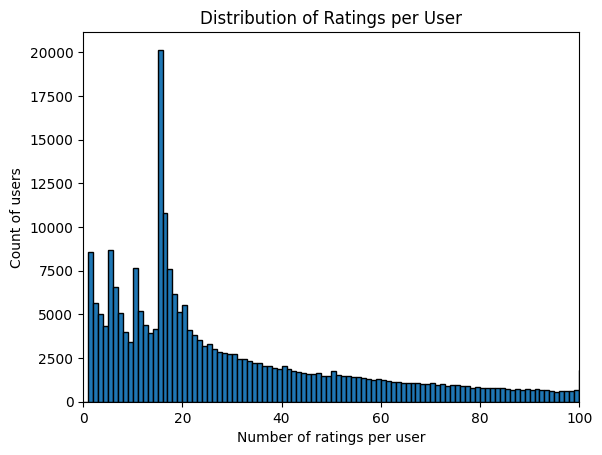

Mean:   102.22
Median: 31.0
Mode:   15
Min:    1
Max:    33332


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Count how many ratings each user has
ratings_per_user = data.groupby('userId').size().values

max_ratings = min(100, ratings_per_user.max())
bins = np.arange(0, max_ratings + 2, 1)

counts, edges = np.histogram(ratings_per_user, bins=bins)

# Barplot
plt.bar(edges[:-1], counts, width=1, edgecolor='black', align='edge')
plt.xlabel("Number of ratings per user")
plt.ylabel("Count of users")
plt.title("Distribution of Ratings per User")
plt.xlim(0, max_ratings)
plt.show()

# Compute statistics
mean_val = np.mean(ratings_per_user)
median_val = np.median(ratings_per_user)
mode_val = stats.mode(ratings_per_user, keepdims=True).mode[0]
min_val = np.min(ratings_per_user)
max_val = np.max(ratings_per_user)

print(f"Mean:   {mean_val:.2f}")
print(f"Median: {median_val}")
print(f"Mode:   {mode_val}")
print(f"Min:    {min_val}")
print(f"Max:    {max_val}")

As can be seen from the last statistics calculated, there seems to be a user that rated 33.332 movies. The mean (102) is also heavily skewed compared to the median (31). Indicating that there might be users that could be considered outliers.

Users seem to be more inclined to rate a movie with a round number of stars (3, 4, 5).

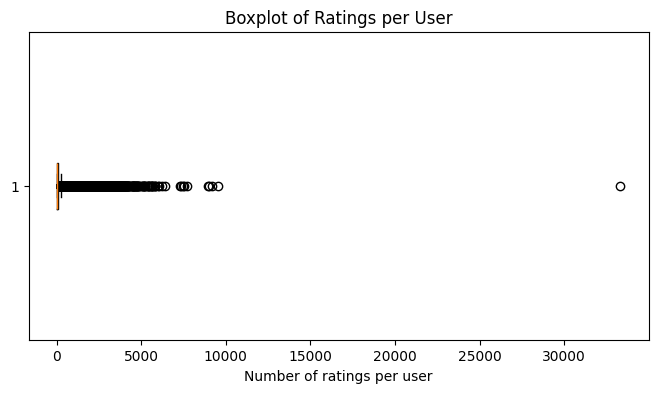

[33332  9554  9178  9016  8919  7719  7535  7488  7372  7266  6380  6199
  6074  5976  5806  5805  5784  5693  5653  5649  5633  5580  5525  5461
  5439]


In [31]:
plt.figure(figsize=(8, 4))
plt.boxplot(ratings_per_user, vert=False, showfliers=True)
plt.xlabel("Number of ratings per user")
plt.title("Boxplot of Ratings per User")
plt.show()

sorted_desc = np.sort(ratings_per_user)[::-1]  # reverse after sort
print(sorted_desc[:25])  # top 20 users by number of ratings


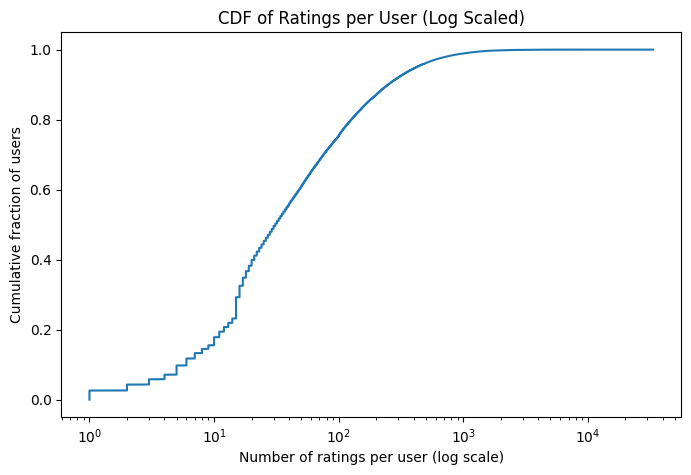

In [26]:
sorted_vals = np.sort(ratings_per_user)
cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)

plt.figure(figsize=(8, 5))
plt.plot(sorted_vals, cdf)
plt.xscale("log")  # 🔹 log scale for x-axis
plt.xlabel("Number of ratings per user (log scale)")
plt.ylabel("Cumulative fraction of users")
plt.title("CDF of Ratings per User (Log Scaled)")
plt.show()


Based on these figures, there definitely seems to be an outlier (or a very big movie fan) at 33K ratings. This one should definitely be removed.

We can also see the CDF already almost reaches 1 at 1000 ratings per user. We could therefore consider to only look at users with less than 1000 ratings.

In [43]:
# Step 1: Count ratings per user
ratings_per_user = data.groupby('userId').size()

# Step 2: Identify outlier users (> 10000 ratings)
outliers = ratings_per_user[ratings_per_user > 10000]

# Step 3: Filter original data
filtered_data = data[~data['userId'].isin(outliers.index)]

# Step 4: Create table of removed users
removed_users_table = outliers.reset_index()
removed_users_table.columns = ['userId', 'num_ratings']

print(removed_users_table)


   userId  num_ratings
0  189614        33332
